# Parallel Tempering

In [16]:
library(adaptMCMC)
library(coda)
library(MASS)
library(sn)
library(ggplot2)

* ## Synthetic data

In [2]:
mu.true <- 20
sigma.true <- 2
data <- rnorm(n=200, mean=mu.true, sd=sigma.true)

* ## Log-posterior distribution

In [7]:
loglike <- function(params, data){
    return (sum(dnorm(data, mean=abs(params[1]), sd=params[2], log=TRUE)))
}

logprior <- function(params){
    return (dunif(params[1], min=-10000, max=10000, log=TRUE)+dunif(params[2], min=0, max=100, log=TRUE))
}

logpost <- function(params, data, temp){
    lp <- logprior(params)
    if (is.infinite(lp)){
        return(-Inf)
    }
    ll <- loglike(params, data)
    return (temp*(ll+lp))
}

* ## Temperature schedules

In [4]:
temp.schedules <- function(nchains, deltaT){
    temps <- c()
    for (i in seq(1, nchains)){
        temps <- c(temps, 1/(1+deltaT*(i-1)))
    }
    return (temps)
}

* ## Algorithm implementation

In [5]:
repexMCMC <- function(nchains, temp_intervals, initials, logposterior, data, ncycles, cycle, covariance_matrix, nparams){
    ntrials <- 0
    nswaps <- 0
    output <- list()
    for (i in 1:nchains){
        output[[i]] <- list()
        output[[i]]$samples <- matrix(nrow=1+ncycles*cycle, ncol=nparams)
        output[[i]]$samples[1, ] <- initials[i, ]
        output[[i]]$log.p <- rep(0, 1+ncycles*cycle)
        output[[i]]$log.p[1] <- logposterior(initials[i, ], data, temp_intervals[i])
    }
    for (i in 1:ncycles){
        for (j in 1:cycle){
            index <- (i-1)*cycle+j
            for (k in 1:nchains){
                currentState <- output[[k]]$samples[index, ]
                currentLog.p <- output[[k]]$log.p[index]
                proposalState <- mvrnorm(n=1, mu=currentState, Sigma=covariance_matrix)
                proposalLog.p <- logposterior(proposalState, data, temp_intervals[k])
                P.accept <- min(0, proposalLog.p-currentLog.p)
                U <- runif(n=1, min=0, max=1)
                if (log(U) < P.accept){
                    output[[k]]$samples[index+1, ] <- proposalState
                    output[[k]]$log.p[index+1] <- proposalLog.p
                }
                else{
                    output[[k]]$samples[index+1, ] <- currentState
                    output[[k]]$log.p[index+1] <- currentLog.p
                }
            }
        }
        ntrials <- ntrials+1
        couple <- sample(1:nchains, size=2); c1 <- couple[1]; c2 <- couple[2]
        x <- output[[c1]]$samples[index+1, ]; y<- output[[c2]]$samples[index+1, ]
        P.swap <- min(0, logposterior(y, data=data, temp=temp_intervals[c1])+
                         logposterior(x, data=data, temp=temp_intervals[c2])-
                         logposterior(x, data=data, temp=temp_intervals[c1])-
                         logposterior(y, data=data, temp=temp_intervals[c2]))
        U <- runif(n=1, min=0, max=1)
        if (log(U) < P.swap){
            nswaps <- nswaps + 1
            output[[c1]]$samples[index+1, ] <- y; output[[c2]]$samples[index+1, ] <- x
        }
    }
    print (nswaps/ntrials)
    return (output[[1]])
}

* ## Parallel Tempering

In [ ]:
nchains <- 10
deltaT <- 2
temps <- temp.schedules(nchains, deltaT)
init <- 0
cov <- matrix(data=c(0,0), ncol=2, nrow=2)
cov[1,1] <- 1
cov[2,2] <- 1
test.cMCMC <- repexMCMC(10, temps, matrix(data=c(0, 1), ncol=2, nrow=10, byrow=TRUE), logpost, data, 20000, 5, cov, 2)

* ## Regular MCMC

In [9]:
test.rMCMC <- MCMC(p=logpost, 
                   n=100001, 
                   init=c(0, 1),
                   adapt=TRUE,
                   acc.rate=0.234,
                   data=data,
                   temp=1)

  generate 1e+05 samples 


* ## Comparsion

png 
  2

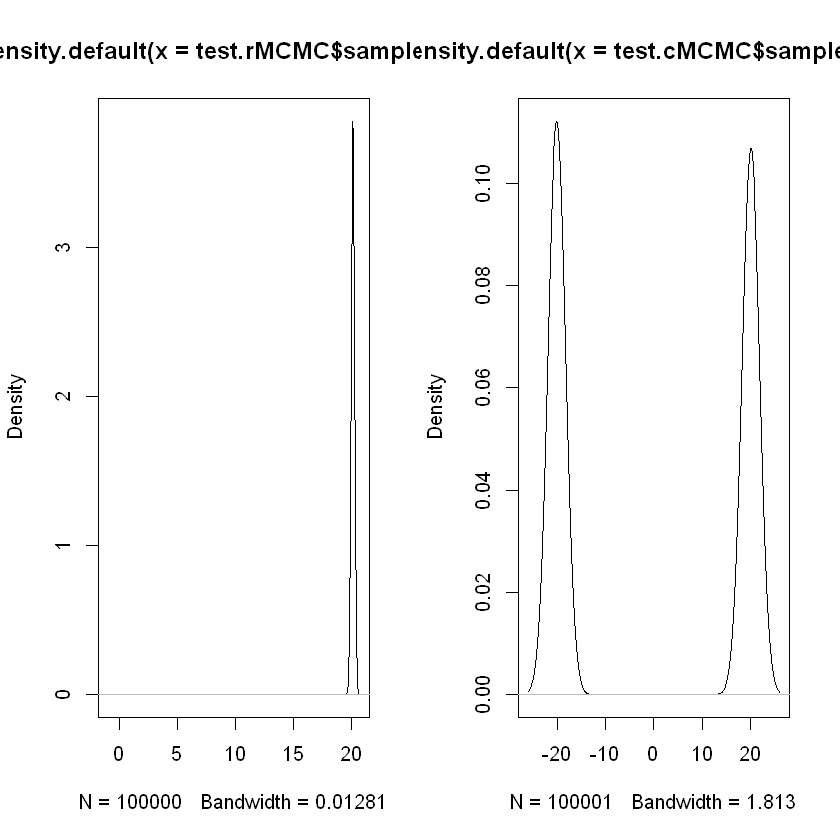

In [33]:
d.rmcmc <- density(test.rMCMC$samples[, 1])
d.cmcmc <- density(test.cMCMC$samples[, 1])

par(mfrow=c(1,2))
plot(d.rmcmc)
plot(d.cmcmc)



jpeg('compare.jpg')
par(mfrow=c(1,2))
plot(d.rmcmc)
plot(d.cmcmc)
dev.off()